# <center> <u> ANALYSIS - SURROGATE MODEL FOR WOVEN COMPOSITES BEHAVIOR
The title of the notebook should be coherent with file name. Namely, file name should be:    
*author's initials_progressive number_title.ipynb*    
For example:    
*EF_01_Data Exploration.ipynb*

## Purpose
State the purpose of the notebook.

## Methodology
Quickly describe assumptions and processing steps.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- Cross-validation: divide data into test set, training set, validation set;
- Consider types of errors; mae, rmse, r2-adjusted etc
- Presentation on GP
- Read book, chapter 2
- Visualize results
- What is the optimum number of points needed model 
- Check Excel and use the 400 data point set

# Setup

## Library import
We import all the required Python libraries

In [1]:
#"""Gaussian processes regression. """

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# Modified by: Pete Green <p.l.green@liverpool.ac.uk>
# License: BSD 3 clause

import warnings
from operator import itemgetter

import numpy as np
from scipy.linalg import cholesky, cho_solve, solve_triangular
import scipy.optimize

from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.base import MultiOutputMixin
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array
from sklearn.utils.optimize import _check_optimize_result
from sklearn.utils.validation import _deprecate_positional_args


class GaussianProcessRegressor(MultiOutputMixin,
                               RegressorMixin, BaseEstimator):
    """Gaussian process regression (GPR).

    The implementation is based on Algorithm 2.1 of Gaussian Processes
    for Machine Learning (GPML) by Rasmussen and Williams.

    In addition to standard scikit-learn estimator API,
    GaussianProcessRegressor:

       * allows prediction without prior fitting (based on the GP prior)
       * provides an additional method sample_y(X), which evaluates samples
         drawn from the GPR (prior or posterior) at given inputs
       * exposes a method log_marginal_likelihood(theta), which can be used
         externally for other ways of selecting hyperparameters, e.g., via
         Markov chain Monte Carlo.

    Read more in the :ref:`User Guide <gaussian_process>`.

    .. versionadded:: 0.18

    Parameters
    ----------
    kernel : kernel instance, default=None
        The kernel specifying the covariance function of the GP. If None is
        passed, the kernel "1.0 * RBF(1.0)" is used as default. Note that
        the kernel's hyperparameters are optimized during fitting.

    alpha : float or array-like of shape (n_samples), default=1e-10
        Value added to the diagonal of the kernel matrix during fitting.
        Larger values correspond to increased noise level in the observations.
        This can also prevent a potential numerical issue during fitting, by
        ensuring that the calculated values form a positive definite matrix.
        If an array is passed, it must have the same number of entries as the
        data used for fitting and is used as datapoint-dependent noise level.
        Note that this is equivalent to adding a WhiteKernel with c=alpha.
        Allowing to specify the noise level directly as a parameter is mainly
        for convenience and for consistency with Ridge.

    optimizer : "fmin_l_bfgs_b" or callable, default="fmin_l_bfgs_b"
        Can either be one of the internally supported optimizers for optimizing
        the kernel's parameters, specified by a string, or an externally
        defined optimizer passed as a callable. If a callable is passed, it
        must have the signature::

            def optimizer(obj_func, initial_theta, bounds):
                # * 'obj_func' is the objective function to be minimized, which
                #   takes the hyperparameters theta as parameter and an
                #   optional flag eval_gradient, which determines if the
                #   gradient is returned additionally to the function value
                # * 'initial_theta': the initial value for theta, which can be
                #   used by local optimizers
                # * 'bounds': the bounds on the values of theta
                ....
                # Returned are the best found hyperparameters theta and
                # the corresponding value of the target function.
                return theta_opt, func_min

        Per default, the 'L-BGFS-B' algorithm from scipy.optimize.minimize
        is used. If None is passed, the kernel's parameters are kept fixed.
        Available internal optimizers are::

            'fmin_l_bfgs_b'

    n_restarts_optimizer : int, default=0
        The number of restarts of the optimizer for finding the kernel's
        parameters which maximize the log-marginal likelihood. The first run
        of the optimizer is performed from the kernel's initial parameters,
        the remaining ones (if any) from thetas sampled log-uniform randomly
        from the space of allowed theta-values. If greater than 0, all bounds
        must be finite. Note that n_restarts_optimizer == 0 implies that one
        run is performed.

    normalize_y : boolean, optional (default: False)
        Whether the target values y are normalized, the mean and variance of
        the target values are set equal to 0 and 1 respectively. This is
        recommended for cases where zero-mean, unit-variance priors are used.
        Note that, in this implementation, the normalisation is reversed
        before the GP predictions are reported.

        .. versionchanged:: 0.23

    copy_X_train : bool, default=True
        If True, a persistent copy of the training data is stored in the
        object. Otherwise, just a reference to the training data is stored,
        which might cause predictions to change if the data is modified
        externally.

    random_state : int or RandomState, default=None
        Determines random number generation used to initialize the centers.
        Pass an int for reproducible results across multiple function calls.
        See :term: `Glossary <random_state>`.

    Attributes
    ----------
    X_train_ : array-like of shape (n_samples, n_features) or list of object
        Feature vectors or other representations of training data (also
        required for prediction).

    y_train_ : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values in training data (also required for prediction)

    kernel_ : kernel instance
        The kernel used for prediction. The structure of the kernel is the
        same as the one passed as parameter but with optimized hyperparameters

    L_ : array-like of shape (n_samples, n_samples)
        Lower-triangular Cholesky decomposition of the kernel in ``X_train_``

    alpha_ : array-like of shape (n_samples,)
        Dual coefficients of training data points in kernel space

    log_marginal_likelihood_value_ : float
        The log-marginal-likelihood of ``self.kernel_.theta``

    Examples
    --------
    >>> from sklearn.datasets import make_friedman2
    >>> from sklearn.gaussian_process import GaussianProcessRegressor
    >>> from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
    >>> X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
    >>> kernel = DotProduct() + WhiteKernel()
    >>> gpr = GaussianProcessRegressor(kernel=kernel,
    ...         random_state=0).fit(X, y)
    >>> gpr.score(X, y)
    0.3680...
    >>> gpr.predict(X[:2,:], return_std=True)
    (array([653.0..., 592.1...]), array([316.6..., 316.6...]))

    """
    @_deprecate_positional_args
    def __init__(self, kernel=None, *, alpha=1e-10,
                 optimizer="fmin_l_bfgs_b", n_restarts_optimizer=0,
                 normalize_y=False, copy_X_train=True, random_state=None):
        self.kernel = kernel
        self.alpha = alpha
        self.optimizer = optimizer
        self.n_restarts_optimizer = n_restarts_optimizer
        self.normalize_y = normalize_y
        self.copy_X_train = copy_X_train
        self.random_state = random_state

    def fit(self, X, y):
        """Fit Gaussian process regression model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or list of object
            Feature vectors or other representations of training data.

        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values

        Returns
        -------
        self : returns an instance of self.
        """
        if self.kernel is None:  # Use an RBF kernel as default
            self.kernel_ = C(1.0, constant_value_bounds="fixed") \
                * RBF(1.0, length_scale_bounds="fixed")
        else:
            self.kernel_ = clone(self.kernel)

        self._rng = check_random_state(self.random_state)

        if self.kernel_.requires_vector_input:
            X, y = self._validate_data(X, y, multi_output=True, y_numeric=True,
                                       ensure_2d=True, dtype="numeric")
        else:
            X, y = self._validate_data(X, y, multi_output=True, y_numeric=True,
                                       ensure_2d=False, dtype=None)

        # Normalize target value
        if self.normalize_y:
            self._y_train_mean = np.mean(y, axis=0)
            self._y_train_std = np.std(y, axis=0)

            # Remove mean and make unit variance
            y = (y - self._y_train_mean) / self._y_train_std

        else:
            self._y_train_mean = np.zeros(1)
            self._y_train_std = 1

        if np.iterable(self.alpha) \
           and self.alpha.shape[0] != y.shape[0]:
            if self.alpha.shape[0] == 1:
                self.alpha = self.alpha[0]
            else:
                raise ValueError("alpha must be a scalar or an array"
                                 " with same number of entries as y.(%d != %d)"
                                 % (self.alpha.shape[0], y.shape[0]))

        self.X_train_ = np.copy(X) if self.copy_X_train else X
        self.y_train_ = np.copy(y) if self.copy_X_train else y

        if self.optimizer is not None and self.kernel_.n_dims > 0:
            # Choose hyperparameters based on maximizing the log-marginal
            # likelihood (potentially starting from several initial values)
            def obj_func(theta, eval_gradient=True):
                if eval_gradient:
                    lml, grad = self.log_marginal_likelihood(
                        theta, eval_gradient=True, clone_kernel=False)
                    return -lml, -grad
                else:
                    return -self.log_marginal_likelihood(theta,
                                                         clone_kernel=False)

            # First optimize starting from theta specified in kernel
            optima = [(self._constrained_optimization(obj_func,
                                                      self.kernel_.theta,
                                                      self.kernel_.bounds))]

            # Additional runs are performed from log-uniform chosen initial
            # theta
            if self.n_restarts_optimizer > 0:
                if not np.isfinite(self.kernel_.bounds).all():
                    raise ValueError(
                        "Multiple optimizer restarts (n_restarts_optimizer>0) "
                        "requires that all bounds are finite.")
                bounds = self.kernel_.bounds
                for iteration in range(self.n_restarts_optimizer):
                    theta_initial = \
                        self._rng.uniform(bounds[:, 0], bounds[:, 1])
                    optima.append(
                        self._constrained_optimization(obj_func, theta_initial,
                                                       bounds))
            # Select result from run with minimal (negative) log-marginal
            # likelihood
            lml_values = list(map(itemgetter(1), optima))
            self.kernel_.theta = optima[np.argmin(lml_values)][0]
            self.log_marginal_likelihood_value_ = -np.min(lml_values)
        else:
            self.log_marginal_likelihood_value_ = \
                self.log_marginal_likelihood(self.kernel_.theta,
                                             clone_kernel=False)

        # Precompute quantities required for predictions which are independent
        # of actual query points
        K = self.kernel_(self.X_train_)
        K[np.diag_indices_from(K)] += self.alpha
        try:
            self.L_ = cholesky(K, lower=True)  # Line 2
            # self.L_ changed, self._K_inv needs to be recomputed
            self._K_inv = None
        except np.linalg.LinAlgError as exc:
            exc.args = ("The kernel, %s, is not returning a "
                        "positive definite matrix. Try gradually "
                        "increasing the 'alpha' parameter of your "
                        "GaussianProcessRegressor estimator."
                        % self.kernel_,) + exc.args
            raise
        self.alpha_ = cho_solve((self.L_, True), self.y_train_)  # Line 3
        return self

    def predict(self, X, return_std=False, return_cov=False):
        """Predict using the Gaussian process regression model

        We can also predict based on an unfitted model by using the GP prior.
        In addition to the mean of the predictive distribution, also its
        standard deviation (return_std=True) or covariance (return_cov=True).
        Note that at most one of the two can be requested.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or list of object
            Query points where the GP is evaluated.

        return_std : bool, default=False
            If True, the standard-deviation of the predictive distribution at
            the query points is returned along with the mean.

        return_cov : bool, default=False
            If True, the covariance of the joint predictive distribution at
            the query points is returned along with the mean

        Returns
        -------
        y_mean : ndarray of shape (n_samples, [n_output_dims])
            Mean of predictive distribution a query points

        y_std : ndarray of shape (n_samples,), optional
            Standard deviation of predictive distribution at query points.
            Only returned when `return_std` is True.

        y_cov : ndarray of shape (n_samples, n_samples), optional
            Covariance of joint predictive distribution a query points.
            Only returned when `return_cov` is True.
        """
        if return_std and return_cov:
            raise RuntimeError(
                "Not returning standard deviation of predictions when "
                "returning full covariance.")

        if self.kernel is None or self.kernel.requires_vector_input:
            X = check_array(X, ensure_2d=True, dtype="numeric")
        else:
            X = check_array(X, ensure_2d=False, dtype=None)

        if not hasattr(self, "X_train_"):  # Unfitted;predict based on GP prior
            if self.kernel is None:
                kernel = (C(1.0, constant_value_bounds="fixed") *
                          RBF(1.0, length_scale_bounds="fixed"))
            else:
                kernel = self.kernel
            y_mean = np.zeros(X.shape[0])
            if return_cov:
                y_cov = kernel(X)
                return y_mean, y_cov
            elif return_std:
                y_var = kernel.diag(X)
                return y_mean, np.sqrt(y_var)
            else:
                return y_mean
        else:  # Predict based on GP posterior
            K_trans = self.kernel_(X, self.X_train_)
            y_mean = K_trans.dot(self.alpha_)  # Line 4 (y_mean = f_star)

            # undo normalisation
            y_mean = self._y_train_std * y_mean + self._y_train_mean

            if return_cov:
                v = cho_solve((self.L_, True), K_trans.T)  # Line 5
                y_cov = self.kernel_(X) - K_trans.dot(v)  # Line 6

                # undo normalisation
                y_cov = y_cov * self._y_train_std**2

                return y_mean, y_cov
            elif return_std:
                # cache result of K_inv computation
                if self._K_inv is None:
                    # compute inverse K_inv of K based on its Cholesky
                    # decomposition L and its inverse L_inv
                    L_inv = solve_triangular(self.L_.T,
                                             np.eye(self.L_.shape[0]))
                    self._K_inv = L_inv.dot(L_inv.T)

                # Compute variance of predictive distribution
                y_var = self.kernel_.diag(X)
                y_var -= np.einsum("ij,ij->i",
                                   np.dot(K_trans, self._K_inv), K_trans)

                # Check if any of the variances is negative because of
                # numerical issues. If yes: set the variance to 0.
                y_var_negative = y_var < 0
                if np.any(y_var_negative):
                    warnings.warn("Predicted variances smaller than 0. "
                                  "Setting those variances to 0.")
                    y_var[y_var_negative] = 0.0

                # undo normalisation
                y_var = y_var * self._y_train_std**2

                return y_mean, np.sqrt(y_var)
            else:
                return y_mean

    def sample_y(self, X, n_samples=1, random_state=0):
        """Draw samples from Gaussian process and evaluate at X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or list of object
            Query points where the GP is evaluated.

        n_samples : int, default=1
            The number of samples drawn from the Gaussian process

        random_state : int, RandomState, default=0
            Determines random number generation to randomly draw samples.
            Pass an int for reproducible results across multiple function
            calls.
            See :term: `Glossary <random_state>`.

        Returns
        -------
        y_samples : ndarray of shape (n_samples_X, [n_output_dims], n_samples)
            Values of n_samples samples drawn from Gaussian process and
            evaluated at query points.
        """
        rng = check_random_state(random_state)

        y_mean, y_cov = self.predict(X, return_cov=True)
        if y_mean.ndim == 1:
            y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
        else:
            y_samples = \
                [rng.multivariate_normal(y_mean[:, i], y_cov,
                                         n_samples).T[:, np.newaxis]
                 for i in range(y_mean.shape[1])]
            y_samples = np.hstack(y_samples)
        return y_samples


    def log_marginal_likelihood(self, theta=None, eval_gradient=False,
                                clone_kernel=True):
        """Returns log-marginal likelihood of theta for training data.

        Parameters
        ----------
        theta : array-like of shape (n_kernel_params,) default=None
            Kernel hyperparameters for which the log-marginal likelihood is
            evaluated. If None, the precomputed log_marginal_likelihood
            of ``self.kernel_.theta`` is returned.

        eval_gradient : bool, default=False
            If True, the gradient of the log-marginal likelihood with respect
            to the kernel hyperparameters at position theta is returned
            additionally. If True, theta must not be None.

        clone_kernel : bool, default=True
            If True, the kernel attribute is copied. If False, the kernel
            attribute is modified, but may result in a performance improvement.

        Returns
        -------
        log_likelihood : float
            Log-marginal likelihood of theta for training data.

        log_likelihood_gradient : ndarray of shape (n_kernel_params,), optional
            Gradient of the log-marginal likelihood with respect to the kernel
            hyperparameters at position theta.
            Only returned when eval_gradient is True.
        """
        if theta is None:
            if eval_gradient:
                raise ValueError(
                    "Gradient can only be evaluated for theta!=None")
            return self.log_marginal_likelihood_value_

        if clone_kernel:
            kernel = self.kernel_.clone_with_theta(theta)
        else:
            kernel = self.kernel_
            kernel.theta = theta

        if eval_gradient:
            K, K_gradient = kernel(self.X_train_, eval_gradient=True)
        else:
            K = kernel(self.X_train_)

        K[np.diag_indices_from(K)] += self.alpha
        try:
            L = cholesky(K, lower=True)  # Line 2
        except np.linalg.LinAlgError:
            return (-np.inf, np.zeros_like(theta)) \
                if eval_gradient else -np.inf

        # Support multi-dimensional output of self.y_train_
        y_train = self.y_train_
        if y_train.ndim == 1:
            y_train = y_train[:, np.newaxis]

        alpha = cho_solve((L, True), y_train)  # Line 3

        # Compute log-likelihood (compare line 7)
        log_likelihood_dims = -0.5 * np.einsum("ik,ik->k", y_train, alpha)
        log_likelihood_dims -= np.log(np.diag(L)).sum()
        log_likelihood_dims -= K.shape[0] / 2 * np.log(2 * np.pi)
        log_likelihood = log_likelihood_dims.sum(-1)  # sum over dimensions

        if eval_gradient:  # compare Equation 5.9 from GPML
            tmp = np.einsum("ik,jk->ijk", alpha, alpha)  # k: output-dimension
            tmp -= cho_solve((L, True), np.eye(K.shape[0]))[:, :, np.newaxis]
            # Compute "0.5 * trace(tmp.dot(K_gradient))" without
            # constructing the full matrix tmp.dot(K_gradient) since only
            # its diagonal is required
            log_likelihood_gradient_dims = \
                0.5 * np.einsum("ijl,jik->kl", tmp, K_gradient)
            log_likelihood_gradient = log_likelihood_gradient_dims.sum(-1)

        if eval_gradient:
            return log_likelihood, log_likelihood_gradient
        else:
            return log_likelihood


    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(
                obj_func, initial_theta, method="L-BFGS-B", jac=True,
                bounds=bounds)
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = \
                self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)

        return theta_opt, func_min

    def _more_tags(self):
        return {'requires_fit': False}

In [29]:
# Data manipulation
import modin.pandas as pd
import numpy as np
import math
import csv
import os
from numpy import random
from numpy.linalg import cholesky as chol
import matgrab
from scipy.io import loadmat
from scipy.stats import norm, uniform, beta, multivariate_normal, stats

#Libraries needed for Gaussian regression

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct, WhiteKernel, Matern, RationalQuadratic

# Options for pandas
pd.options.display.max_columns = 10
pd.options.display.max_rows = 20

# Visualizations
from tabulate import tabulate
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib widget
%config InlineBackend.figure_format = 'svg'
plt.style.use("ggplot")

import seaborn as sns
sns.set()
sns.set_context("talk")

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

ModuleNotFoundError: No module named 'modin'

# Gaussian process

**Gaussian processes (GPs)** allow one to model and make predictions about data using GPs. Here's a general outline of how to perform Gaussian processes:

1. **Data Preparation:** Start by collecting or preparing the data with the corresponding observations.

2. **Define the Kernel:** The kernel function, also known as the covariance function or the similarity function, is a crucial component of a Gaussian process. It determines the assumptions made about the underlying process. For time-dependent data, we need to choose a kernel that captures temporal dependencies. Some commonly used kernels for time series data include the squared exponential (also known as the radial basis function or RBF) and the periodic kernel.

3. **Model Training:** Fit the Gaussian process model to the data. This involves estimating the hyperparameters of the kernel, such as length scales and noise levels. The most common approach is to maximize the log marginal likelihood, which measures how well the model fits the training data. Optimization methods like gradient-based algorithms or numerical optimization techniques can be used to find the optimal hyperparameters.

4. **Predictions:** After training the GP model, use it to make predictions on unseen data points. Given a new input (time stamp), the GP model provides a predictive distribution over possible output values. The predictive distribution is typically a Gaussian distribution characterized by its mean and covariance.

5. **Updating the Model:** As new observations become available over time, one can update your Gaussian process model to incorporate the new data. This process is known as online learning or incremental learning. By sequentially updating the model with new data, one can continuously refine the predictions and adapt to changing patterns in the time-dependent process.

In a nutshell, GP regression simply amounts to generating a prediction given some training data through conditioning, under the assumption that the underlying function is a infinite-dimensional vector that follows some Gaussian distribution with a kernel acting as its prior.

## Local library import
We import all the required local libraries libraries

In [4]:
# Include local library paths
import os
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.


# Data import
We retrieve all the required data for the analysis.

## Help Functions

In [3]:
#Check current path
print(os.getcwd())

/Users/Ian_1/Desktop/MASTER THESIS WORK/Documents


In [6]:
meanfield = loadmat("/Volumes/NO NAME/MASTER THESIS WORK/Data/WovenMeanField.mat")
meanfield_glob_scaled = loadmat("/Volumes/NO NAME/MASTER THESIS WORK/Data/WovenMeanField_GloballyScaled_0_1_fixedFeatures.mat")
timeindepdata = '/Volumes/NO NAME/MASTER THESIS WORK/Data/features_final_version.xlsx'

## Gaussian process for time-independent sequential data

In [7]:
#Unpack our data by stacking different lists vertically
def stack(data):
    for i in data:
        for j in i:
            x_test_stack = np.vstack(j)
    return(x_test_stack)

#Prepare data for GPy
def gpyarrange(data):
    for i in data:
        i.reshape((-1,1))
    return(data)

#Check for structure of data
def get_structure(data):
    print('The data is of shape', data.shape, 'and of dimension', data.ndim)
    
def MSE_analysis(array1, array2):
    """
    Takes two arrays and comparatively calculates the MSE for each corresponding entry.
    """
    assert array1.shape == array2.shape, "The two arrays should be of the same dimension"
    y_pred_error = np.zeros((array1.shape[0], array2.shape[1]))
    for i in range(array1.shape[0]):
        for j in range(array2.shape[1]):
            y_pred_error[i][j] = np.square(np.subtract(array1[i][j],array2[i][j])).mean()
    return (y_pred_error, pd.DataFrame(y_pred_error) )

def RMSE_analysis(array1, array2):
    """
    Takes two arrays and comparatively calculates the MSE for each corresponding entry.
    """
    assert array1.shape == array2.shape, "The two arrays should be of the same dimension"
    y_pred_error = np.zeros((array1.shape[0], array2.shape[1]))
    for i in range(array1.shape[0]):
        for j in range(array2.shape[1]):
            y_pred_error[i][j] = math.sqrt( np.square(np.subtract(array1[i][j],array2[i][j])).mean() )
    return (y_pred_error, pd.DataFrame(y_pred_error) )

def data_split(df):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    return(train_df,val_df,test_df)

In [8]:
#data_points = 'InputForKeras-300datapoint'
data_points = 'InputForKeras'
df = pd.read_excel(timeindepdata, sheet_name = data_points)
columns = ['phiF','EM','nuM','EF','nuF','E11','E22','nu12','nu13','nu23','G12','G13','G23']
input_features = ['phiF','EM','nuM','EF','nuF']
output_features = ['E11','E22','nu12','nu13','nu23','G12','G13','G23']
df = df[columns]
df

,phiF,EM,nuM,EF,nuF,...,nu13,nu23,G12,G13,G23
0,0.450000,6750.000000,0.370000,427550.000000,0.300000,...,0.334033,0.470433,7214.333,6945.667,7341.000
1,0.525000,8375.000000,0.310000,606825.000000,0.250000,...,0.272510,0.372067,12258.000,11407.670,11501.670
2,0.375000,5125.000000,0.430000,248275.000000,0.350000,...,0.395900,0.600233,4067.667,4173.000,4648.667
3,0.562500,5937.500000,0.340000,517187.500000,0.225000,...,0.262243,0.358133,9092.333,9351.000,9260.333
4,0.412500,9187.500000,0.460000,158637.500000,0.325000,...,0.404333,0.614533,7516.667,7277.333,8925.000
...,...,...,...,...,...,...,...,...,...,...,...
395,0.546680,5594.726562,0.274844,512985.742188,0.232422,...,0.246130,0.309010,8954.333,8817.667,8115.000
396,0.396680,8844.726562,0.394844,154435.742188,0.332422,...,0.367000,0.487067,7465.000,7178.000,7396.000
397,0.321680,7219.726562,0.334844,333710.742188,0.282422,...,0.314077,0.426367,5717.333,5496.667,5199.000
398,0.471680,3969.726562,0.454844,692260.742188,0.382422,...,0.417967,0.656067,4362.000,4442.667,6362.667


In [9]:
print(( df.head(5) ).to_latex(index=False, formatters={"name": str.upper},float_format="{:.1f}".format,
))  

\begin{tabular}{rrrrrrrrrrrrr}
\toprule
 phiF &     EM &  nuM &       EF &  nuF &      E11 &     E22 &  nu12 &  nu13 &  nu23 &     G12 &     G13 &     G23 \\
\midrule
  0.4 & 6750.0 &  0.4 & 427550.0 &  0.3 & 192266.7 & 20762.0 &   0.3 &   0.3 &   0.5 &  7214.3 &  6945.7 &  7341.0 \\
  0.5 & 8375.0 &  0.3 & 606825.0 &  0.2 & 315116.7 & 29356.3 &   0.3 &   0.3 &   0.4 & 12258.0 & 11407.7 & 11501.7 \\
  0.4 & 5125.0 &  0.4 & 248275.0 &  0.4 &  95003.3 & 14848.3 &   0.4 &   0.4 &   0.6 &  4067.7 &  4173.0 &  4648.7 \\
  0.6 & 5937.5 &  0.3 & 517187.5 &  0.2 & 286410.0 & 24470.7 &   0.3 &   0.3 &   0.4 &  9092.3 &  9351.0 &  9260.3 \\
  0.4 & 9187.5 &  0.5 & 158637.5 &  0.3 &  69846.7 & 30029.7 &   0.4 &   0.4 &   0.6 &  7516.7 &  7277.3 &  8925.0 \\
\bottomrule
\end{tabular}



/var/folders/cb/vrjht0fx48d3g_xc6hc9qphw0000gn/T/ipykernel_55424/4012393963.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(( df.head(5) ).to_latex(index=False, formatters={"name": str.upper},float_format="{:.1f}".format,


### Evaluate dataset

#### Plot sample input feature

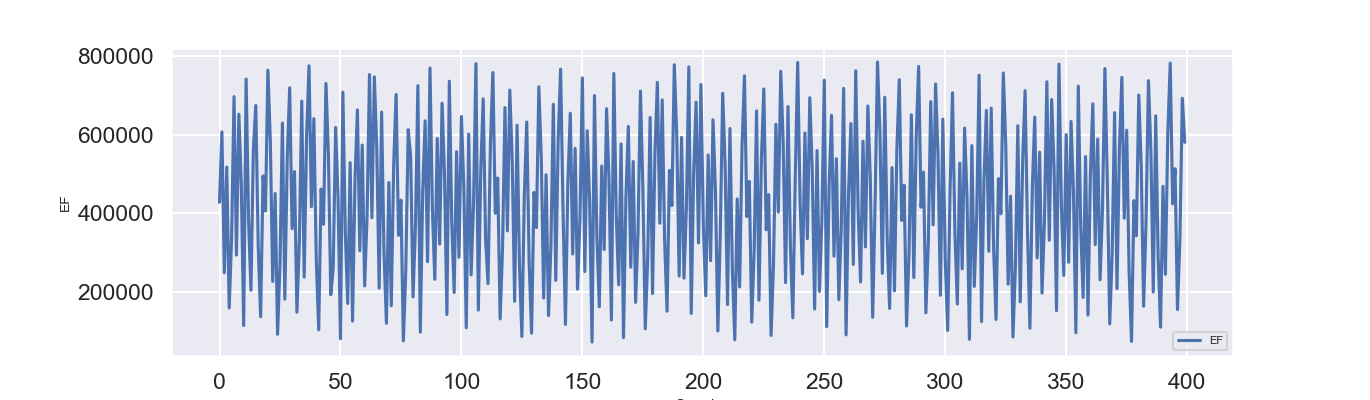

In [10]:
plt.figure(figsize=(13.7,4))
plt.plot(range(len(df)),df['EF'], label = "EF")
plt.xlabel('Samples', fontsize=10)
plt.ylabel('EF', fontsize=10)
plt.legend(loc=4, prop={'size': 8})
plt.show()

#### Split dataset into training and test set

In [11]:
"""Our training dataset is 90% of the original dataset"""
test_data = df.sample(frac = 0.1)
training_data = df.drop(test_data.index)

In [12]:
training_data

,phiF,EM,nuM,EF,nuF,...,nu13,nu23,G12,G13,G23
0,0.450000,6750.000000,0.370000,427550.000000,0.300000,...,0.334033,0.470433,7214.333,6945.667,7341.000
1,0.525000,8375.000000,0.310000,606825.000000,0.250000,...,0.272510,0.372067,12258.000,11407.670,11501.670
2,0.375000,5125.000000,0.430000,248275.000000,0.350000,...,0.395900,0.600233,4067.667,4173.000,4648.667
3,0.562500,5937.500000,0.340000,517187.500000,0.225000,...,0.262243,0.358133,9092.333,9351.000,9260.333
4,0.412500,9187.500000,0.460000,158637.500000,0.325000,...,0.404333,0.614533,7516.667,7277.333,8925.000
...,...,...,...,...,...,...,...,...,...,...,...
394,0.434180,6407.226562,0.424844,423348.242188,0.357422,...,0.392000,0.563467,6403.333,6324.000,7364.333
395,0.546680,5594.726562,0.274844,512985.742188,0.232422,...,0.246130,0.309010,8954.333,8817.667,8115.000
396,0.396680,8844.726562,0.394844,154435.742188,0.332422,...,0.367000,0.487067,7465.000,7178.000,7396.000
397,0.321680,7219.726562,0.334844,333710.742188,0.282422,...,0.314077,0.426367,5717.333,5496.667,5199.000


In [13]:
print(( training_data.head(5) ).to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,
))  

\begin{tabular}{rrrrrrrrrrrrr}
\toprule
 phiF &     EM &  nuM &       EF &  nuF &      E11 &     E22 &  nu12 &  nu13 &  nu23 &     G12 &     G13 &     G23 \\
\midrule
  0.4 & 6750.0 &  0.4 & 427550.0 &  0.3 & 192266.7 & 20762.0 &   0.3 &   0.3 &   0.5 &  7214.3 &  6945.7 &  7341.0 \\
  0.5 & 8375.0 &  0.3 & 606825.0 &  0.2 & 315116.7 & 29356.3 &   0.3 &   0.3 &   0.4 & 12258.0 & 11407.7 & 11501.7 \\
  0.4 & 5125.0 &  0.4 & 248275.0 &  0.4 &  95003.3 & 14848.3 &   0.4 &   0.4 &   0.6 &  4067.7 &  4173.0 &  4648.7 \\
  0.6 & 5937.5 &  0.3 & 517187.5 &  0.2 & 286410.0 & 24470.7 &   0.3 &   0.3 &   0.4 &  9092.3 &  9351.0 &  9260.3 \\
  0.4 & 9187.5 &  0.5 & 158637.5 &  0.3 &  69846.7 & 30029.7 &   0.4 &   0.4 &   0.6 &  7516.7 &  7277.3 &  8925.0 \\
\bottomrule
\end{tabular}



/var/folders/cb/vrjht0fx48d3g_xc6hc9qphw0000gn/T/ipykernel_55424/64335687.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(( training_data.head(5) ).to_latex(index=False,


In [14]:
"""Our test dataset is 10% of the original dataset"""
test_data

,phiF,EM,nuM,EF,nuF,...,nu13,nu23,G12,G13,G23
157,0.467578,7029.296875,0.337187,161438.671875,0.257031,...,0.292080,0.387000,7447.000,7520.000,7264.667
318,0.329883,3639.648438,0.418281,302897.851562,0.378516,...,0.404133,0.608333,2767.300,2654.733,2775.933
266,0.306445,6381.835938,0.474531,583015.039062,0.244141,...,0.408067,0.769967,4414.000,4145.333,5152.667
255,0.550195,3538.085938,0.369531,538196.289062,0.256641,...,0.297077,0.428733,5399.667,5318.333,5743.333
233,0.493359,9822.265625,0.346562,581614.453125,0.271094,...,0.301907,0.395733,12133.000,11924.670,12032.000
...,...,...,...,...,...,...,...,...,...,...,...
37,0.473437,7867.187500,0.343750,774895.312500,0.390625,...,0.370567,0.410100,9184.667,9339.333,9090.000
382,0.355664,3588.867188,0.450156,162839.257812,0.233203,...,0.362367,0.655200,2639.800,2813.333,3059.300
122,0.330469,5988.281250,0.439375,175444.531250,0.251563,...,0.375933,0.634433,4316.667,4158.000,4484.667
247,0.352734,4337.890625,0.339062,559205.078125,0.289844,...,0.316517,0.419133,3537.000,3786.333,3413.667


In [15]:
print(( test_data.head(5) ).to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,
))  

\begin{tabular}{rrrrrrrrrrrrr}
\toprule
 phiF &     EM &  nuM &       EF &  nuF &      E11 &     E22 &  nu12 &  nu13 &  nu23 &     G12 &     G13 &     G23 \\
\midrule
  0.5 & 7029.3 &  0.3 & 161438.7 &  0.3 &  78846.7 & 19836.3 &   0.3 &   0.3 &   0.4 &  7447.0 &  7520.0 &  7264.7 \\
  0.3 & 3639.6 &  0.4 & 302897.9 &  0.4 &  99906.7 &  9401.7 &   0.4 &   0.4 &   0.6 &  2767.3 &  2654.7 &  2775.9 \\
  0.3 & 6381.8 &  0.5 & 583015.0 &  0.2 & 178460.0 & 23472.7 &   0.4 &   0.4 &   0.8 &  4414.0 &  4145.3 &  5152.7 \\
  0.6 & 3538.1 &  0.4 & 538196.3 &  0.3 & 290483.3 & 15561.0 &   0.3 &   0.3 &   0.4 &  5399.7 &  5318.3 &  5743.3 \\
  0.5 & 9822.3 &  0.3 & 581614.5 &  0.3 & 289186.7 & 33250.3 &   0.3 &   0.3 &   0.4 & 12133.0 & 11924.7 & 12032.0 \\
\bottomrule
\end{tabular}



/var/folders/cb/vrjht0fx48d3g_xc6hc9qphw0000gn/T/ipykernel_55424/1208241602.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(( test_data.head(5) ).to_latex(index=False,


### Cross-validation

In [16]:
#cv_scores = cross_val_score(mat_gpr, xtrain, ytrain, cv=20)
#print("Cross Validation Scores: ", cv_scores)
#print("Average CV Score: ", cv_scores.mean())
#print("Number of CV Scores used in Average: ", len(cv_scores))

In [17]:
#cv_results = cross_validate(mat_gpr, xtrain, ytrain, cv=20, return_estimator=True)
## Print the results
#print("Cross Validation training scores: ", cv_results['test_score'])
#print("Average CV training score: ", cv_results['test_score'].mean())
#print("Number of CV training scores used in Average: ", len(cv_results['test_score']))

In [18]:
#val_test_score = []
#for i in range(len(cv_results['estimator'])):
#    val_test_score.append(cv_results['estimator'][i].score(xtest, ytest))

In [19]:
#sum(val_test_score) / len(val_test_score)

### A note on kernels

Increasing the lengthscale parameter l increases the spread of the covariance. Increasing the amplitude parameter sigma increases the maximum value of the covariance.

### Training our model

In [20]:
"""Create arrays and dataframes to store results after training"""
training_points = []
err_col = [u'\u00B1'+'E11', u'\u00B1'+'E22', u'\u00B1'+'nu12', u'\u00B1'+'nu13', u'\u00B1'+'nu23', u'\u00B1'+'G12', u'\u00B1'+'G13', u'\u00B1'+'G23']
test_RMSE_array = np.array([])
validation_RMSE_array = np.array([])

#res_col = ['Percentage of dp', 'Model training dp', 'Model testing dp' , 'Kernel' , 'MSE testing' , 'MSE validation', 'RMSE testing' , 'RMSE validation']
#results_df = pd.DataFrame(columns = res_col)
#results = np.ndarray((0, len(columns)))
mod_rmse_arr = np.zeros( len(err_col) )
mod_std_arr = np.zeros( len(err_col) )
test_rmse_arr = np.zeros( len(err_col) )
test_std_arr = np.zeros( len(err_col) )

#nu_arr = [0.5, 1.5, 2.5, math.inf]

for i in [ x for x in range(50,96,1) ]:
    
    """Sample the training dataset"""
    train = training_data.sample(frac = i*0.01) #Sample them randomly
    
    """Extract the features and outputs"""
    xtrain = train[input_features]
    ytrain = train[output_features]
    xtest = test_data[input_features]
    ytest = test_data[output_features]
    
    """Define scaler"""
    x_scaler = preprocessing.MinMaxScaler()
    y_scaler = preprocessing.MinMaxScaler()
    transformer_x = x_scaler.fit(xtrain)
    transformer_y = y_scaler.fit(ytrain)
    
    scaled_xtrain = transformer_x.transform(xtrain)
    scaled_ytrain = transformer_y.transform(ytrain)
    scaled_xtest = transformer_x.transform(xtest)
    scaled_ytest = transformer_y.transform(ytest)
    
    
    """Training the model"""
    
    """The parameter nu controlling the smoothness of the learned function. The smaller nu, the less smooth the approximated function is.
       For nu=inf, the kernel becomes equivalent to the RBF kernel and for nu=0.5 to the absolute exponential kernel.
       Important intermediate values are nu=1.5 (once differentiable functions) and nu=2.5 (twice differentiable functions).
       Note that values of nu not in [0.5, 1.5, 2.5, inf] incur a considerably higher computational cost (appr. 10 times higher) since they require to evaluate the modified Bessel function.
       Furthermore, in contrast to l, nu is kept fixed to its initial value and not optimized."""
        
    #kernel = Matern(length_scale=1e-3, length_scale_bounds = (1e-05,1e5), nu=1.5)
    #kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * Matern(length_scale=1e-3, length_scale_bounds=(1e-05, 1e5), nu=1.5)
    #kernel = RationalQuadratic(length_scale=1e-3, alpha=1.0, length_scale_bounds=(1e-05, 100000.0), alpha_bounds=(1e-05, 100000.0))
    kernel = 1.0 * RBF( length_scale=1.0, length_scale_bounds=(1e-05, 100000.0) )
    
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
    gpr.fit(scaled_xtrain, scaled_ytrain)     
              

    """Test using hidden dataset"""
    test_ypred, test_std_prediction = gpr.predict(scaled_xtest, return_std=True)
    test_data_MSE = mean_squared_error( np.array(scaled_ytest), np.array(test_ypred) )
    test_data_RMSE = math.sqrt(test_data_MSE)
    test_RMSE_array = np.append(test_RMSE_array, test_data_RMSE)
    #training_points = np.append( training_points, len(model_data) - (len(model_data)*i*0.01) - len(model_data)*0.2 )
    
    """Checking errors and standard deviation across the predictions on the individual features"""
    """During testing"""
    test_RMSE = np.zeros( len(err_col) )
    test_STD = np.zeros( len(err_col) )
    for j in range( np.shape(test_ypred)[1] ):
        test_RMSE[j] = math.sqrt( mean_squared_error( np.array(scaled_ytest)[:,j], np.array(test_ypred)[:,j] ) )
        test_STD[j] = np.std( test_ypred[:,j] )
    test_rmse_arr = np.vstack( (test_rmse_arr, test_RMSE) )
    test_std_arr = np.vstack( (test_std_arr, test_STD) )
    
    if i == 95:
        unscaled_test_rmse_arr = transformer_y.inverse_transform(test_rmse_arr)
        unscaled_test_std_arr  = transformer_y.inverse_transform(test_std_arr)
    ##"""PLOT KERNEL """ 
    ##percentiles = [50,60,70,80,90]
    ##if i in percentiles:
    #if i == 50:
    #    plt.figure(figsize=(13.7,5))
    #    y_samples = gpr.sample_y(scaled_xtrain, n_samples=5, random_state=0)
    #    #y_samples.reshape(-1, 1)
    #    plt.plot([ a for a in range( len(scaled_xtrain[:,0]) ) ], y_samples[:,0], lw=1)
    #    #plt.xlim(0, 5)
    #    #plt.ylim(-3, 3)
    #    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)
    #    plt.show()
    
    
    #""" Get the average over errors on output features and std per feature, Use simpler kernels"""
    #"""During validation"""
    #for j in range( np.shape(mod_ypred)[1] ):
    #    mse_mod = np.zeros( len(err_col) )
    #    mse_mod[j] = math.sqrt( mean_squared_error(mod_ytest[:,j], mod_ypred[:,j]) )
    #    std_mod = np.zeros( len(err_col) )
    #    std_mod[j] = np.std( mod_ypred[:,j] )
    #mod_rmse_arr = np.vstack( (mod_rmse_arr, mse_mod) )
    #mod_std_arr = np.vstack( (mod_std_arr, std_mod) )


    
    """Print results"""
    print( round(i),"% OF DATASET USED FOR MODELING, 10% USED FOR TESTING,")
    print("Datapoints used for model training:", len(train) )
    print("Datapoints used for model testing:", len(test_data) )
    print("Kernel:", gpr.kernel_)
    print("Test MSE:", test_data_MSE)
    print("Test RMSE:", test_data_RMSE) 
    print('----------------------------------------------------------------')
    
    #txt = "RationalQuadratic(alpha=0.092, length_scale=3.15)"
    #txt = txt.replace("(alpha=",",").replace("length_scale=","")
    #txt
    
    #results = np.append(results, np.array([[ round(i), len(mod_xtrain), len(mod_xtest) , gpr.kernel_ , mod_mse, hidden_data_mse, mod_RMSE , hidden_data_RMSE ]]), axis=0)

50 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 180
Datapoints used for model testing: 40
Kernel: 0.3**2 * RBF(length_scale=0.541)
Test MSE: 0.0021185644098591326
Test RMSE: 0.046027865580093245
----------------------------------------------------------------
51 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 184
Datapoints used for model testing: 40
Kernel: 0.286**2 * RBF(length_scale=0.506)
Test MSE: 0.003230159038976907
Test RMSE: 0.05683448811220971
----------------------------------------------------------------
52 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 187
Datapoints used for model testing: 40
Kernel: 0.297**2 * RBF(length_scale=0.517)
Test MSE: 0.0027592532011467674
Test RMSE: 0.05252859412878635
----------------------------------------------------------------


/Users/Ian_1/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


53 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 191
Datapoints used for model testing: 40
Kernel: 0.421**2 * RBF(length_scale=1e-05)
Test MSE: 0.19540297529986125
Test RMSE: 0.4420440875069604
----------------------------------------------------------------
54 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 194
Datapoints used for model testing: 40
Kernel: 0.305**2 * RBF(length_scale=0.526)
Test MSE: 0.002792289093936164
Test RMSE: 0.052842114775396375
----------------------------------------------------------------
55 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 198
Datapoints used for model testing: 40
Kernel: 0.299**2 * RBF(length_scale=0.503)
Test MSE: 0.0031417446572710376
Test RMSE: 0.056051268114745076
----------------------------------------------------------------
56 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model t

/Users/Ian_1/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


76 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 274
Datapoints used for model testing: 40
Kernel: 0.432**2 * RBF(length_scale=1e-05)
Test MSE: 0.2061359927738218
Test RMSE: 0.45402201793946273
----------------------------------------------------------------
77 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 277
Datapoints used for model testing: 40
Kernel: 0.272**2 * RBF(length_scale=0.458)
Test MSE: 0.003102675034439582
Test RMSE: 0.05570166096661375
----------------------------------------------------------------
78 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 281
Datapoints used for model testing: 40
Kernel: 0.273**2 * RBF(length_scale=0.464)
Test MSE: 0.0016661067047291764
Test RMSE: 0.04081797036513668
----------------------------------------------------------------
79 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model tra

In [27]:
pd.DataFrame(scaled_ytest, columns = output_features)

,E11,E22,nu12,nu13,nu23,G12,G13,G23
0,0.165559,0.188129,0.296721,0.286283,0.239842,0.386378,0.384775,0.222763
1,0.212708,0.056733,0.787834,0.776262,0.639229,0.071617,0.062980,0.042990
2,0.388572,0.233919,0.750602,0.793461,0.930889,0.182376,0.161570,0.138178
3,0.639369,0.134293,0.317716,0.308132,0.315148,0.248673,0.239154,0.161834
4,0.636466,0.357042,0.341312,0.329252,0.255601,0.701563,0.676106,0.413695
...,...,...,...,...,...,...,...,...
35,0.805076,0.255754,0.649099,0.629484,0.281525,0.503256,0.505108,0.295868
36,0.120567,0.074479,0.654271,0.593628,0.723798,0.063042,0.073470,0.054339
37,0.124731,0.132055,0.631222,0.652951,0.686325,0.175829,0.162408,0.111425
38,0.428311,0.062571,0.415791,0.393138,0.297826,0.123388,0.137825,0.068531


In [22]:
pd.DataFrame(test_ypred, columns = output_features)

,E11,E22,nu12,nu13,nu23,G12,G13,G23
0,0.168017,0.199944,0.295183,0.300578,0.273809,0.389403,0.351508,0.242560
1,0.011832,-0.011832,0.853280,0.842788,0.230796,-0.009705,0.021639,0.039256
2,0.345749,0.230793,0.693727,0.791815,0.870319,0.176411,0.164585,0.134417
3,0.610415,0.149324,0.312013,0.325646,0.311130,0.251187,0.215382,0.160234
4,0.636727,0.365625,0.337558,0.312044,0.198008,0.710689,0.729218,0.431628
...,...,...,...,...,...,...,...,...
35,0.661349,0.130555,0.646996,0.635300,0.429702,0.376590,0.273336,0.132695
36,0.112683,0.091214,0.550355,0.617588,0.669046,0.028973,0.028716,0.039380
37,0.114068,0.140393,0.630954,0.682202,0.670055,0.181087,0.160226,0.125626
38,0.450670,0.074112,0.399404,0.389332,0.311082,0.146896,0.140598,0.082681


In [23]:
pd.DataFrame( data=test_rmse_arr, columns = output_features ).iloc[1:]

,E11,E22,nu12,nu13,nu23,G12,G13,G23
1,0.028655,0.035180,0.038777,0.036344,0.057513,0.067396,0.044783,0.047008
2,0.059566,0.039114,0.047302,0.036389,0.106073,0.049637,0.047342,0.035287
3,0.052628,0.041374,0.047903,0.046782,0.078392,0.052031,0.049137,0.042921
4,0.484970,0.261531,0.566784,0.557247,0.500581,0.402922,0.374521,0.273254
5,0.051512,0.047961,0.041003,0.034076,0.092095,0.044941,0.047224,0.042555
...,...,...,...,...,...,...,...,...
42,0.050264,0.042705,0.030408,0.029595,0.096645,0.044735,0.053608,0.047307
43,0.051050,0.037090,0.030855,0.027474,0.089453,0.041499,0.042714,0.045367
44,0.050619,0.030903,0.037977,0.027763,0.103360,0.048736,0.047496,0.034709
45,0.050590,0.031121,0.033163,0.024897,0.086524,0.049915,0.046829,0.037268


In [24]:
pd.DataFrame( data=unscaled_test_rmse_arr, columns = output_features ).iloc[1:]

,E11,E22,nu12,nu13,nu23,G12,G13,G23
1,17695.650062,7690.075776,0.233239,0.234921,0.285956,2704.538451,2379.613026,2876.265706
2,31502.478396,8002.494417,0.235162,0.234932,0.312867,2440.505957,2418.305531,2583.599272
3,28403.800464,8181.995034,0.235297,0.237309,0.297527,2476.097296,2445.440789,2774.223095
4,221518.246624,25665.436342,0.352362,0.354047,0.531497,7692.963933,7364.970513,8525.360277
5,27905.226348,8705.116680,0.233741,0.234403,0.305121,2370.683708,2416.516339,2765.069223
...,...,...,...,...,...,...,...,...
42,27347.975005,8287.710405,0.231350,0.233378,0.307642,2367.620205,2513.037921,2883.719452
43,27698.806257,7841.769636,0.231451,0.232893,0.303656,2319.514790,2348.328130,2835.293923
44,27506.428128,7350.446341,0.233058,0.232959,0.311364,2427.114503,2420.635170,2569.182335
45,27493.365011,7367.791599,0.231972,0.232304,0.302034,2444.644275,2410.542822,2633.058441


In [25]:
test_data[output_features]

,E11,E22,nu12,nu13,nu23,G12,G13,G23
157,78846.67,19836.330,0.291433,0.292080,0.387000,7447.000,7520.000,7264.667
318,99906.67,9401.667,0.402233,0.404133,0.608333,2767.300,2654.733,2775.933
266,178460.00,23472.670,0.393833,0.408067,0.769967,4414.000,4145.333,5152.667
255,290483.30,15561.000,0.296170,0.297077,0.428733,5399.667,5318.333,5743.333
233,289186.70,33250.330,0.301493,0.301907,0.395733,12133.000,11924.670,12032.000
...,...,...,...,...,...,...,...,...
37,364500.00,25206.670,0.370933,0.370567,0.410100,9184.667,9339.333,9090.000
382,58750.00,10811.000,0.372100,0.362367,0.655200,2639.800,2813.333,3059.300
122,60610.00,15383.330,0.366900,0.375933,0.634433,4316.667,4158.000,4484.667
247,196210.00,9865.333,0.318297,0.316517,0.419133,3537.000,3786.333,3413.667


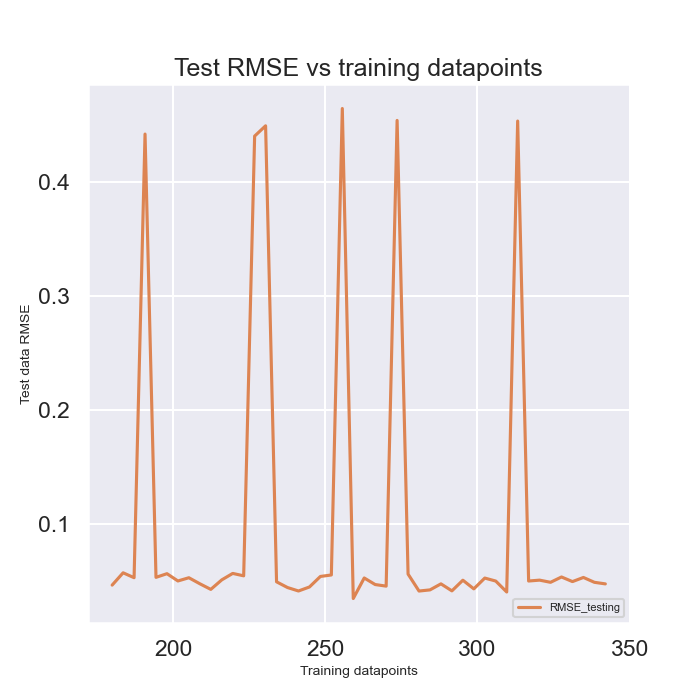

In [28]:
"""
Plot unscaled test RMSE
Plot for multiple tries
"""

plt.close()
plt.figure(figsize=(7,7))
plt.title( "Test RMSE vs training datapoints")
plt.plot( [ len(training_data)*0.01*i for i in range(50,96,1) ] ,test_RMSE_array, label = "RMSE_testing", color='C1')
plt.xlabel('Training datapoints',fontsize=10)
plt.ylabel('Test data RMSE',fontsize=10)
plt.legend(loc=4,prop={'size': 8})
#plt.legend(["First data with {}".format(input_var1),"Second data with {}".format(input_var2)])
plt.savefig('RMSE_testing_400_MinMaxScaler.png',bbox_inches='tight')
plt.show()


In [ ]:
ytest

In [ ]:
prediction = scaler.inverse_transform(test_ypred)
prediction_df = pd.DataFrame(prediction, columns=output_features)
prediction_df

In [ ]:
#plt.close()
#plt.figure(figsize=(7,7))
#plt.title("RMSE validation vs training datapoints")
#plt.plot( [ len(model_data)*0.01*i for i in range(20,80,1) ] ,RMSE_validation_array, label = "RMSE_validation", color='C1')
##plt.plot( [ len(model_data)*0.01*i for i in range(20,90,1) ] ,RMSE_training_array[::-1], label = "RMSE_training")
#plt.xlabel('Datapoints',fontsize=10)
#plt.ylabel('Validation RMSE',fontsize=10)
#plt.legend(loc=4,prop={'size': 8})
#plt.savefig('RMSE_validation_400.png',bbox_inches='tight')
#plt.show()

#RMSE_validation_array

In [ ]:
test_ypred_df = pd.DataFrame(data=test_ypred, columns = ['E11','E22','nu12','nu13','nu23','G12','G13','G23'])
test_output_df = pd.DataFrame(data=test_output, columns = ['E11','E22','nu12','nu13','nu23','G12','G13','G23'])
plt.figure(figsize=(15.8,6))
plt.scatter(range(len(test_input)),test_output_df['E11'],label = "test E11", marker="o", color='b')
plt.scatter(range(len(test_ypred)),test_ypred_df['E11'],label = "predicted E11", marker="o", color='r')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('E11', fontsize=10)
plt.legend(loc=4, prop={'size': 8})
plt.show()

### Comparing our ground truth and predicted values

In [ ]:
plt.figure(figsize=(15.8,5))
plt.plot(range(len(y_test_df)), y_test_df['nu12'], 'o', label = "Normalized ytest E11")
plt.plot(range(len(pred_output)), pred_output['nu12'], '*', label = "Normalized ypred E11", color='C1')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('Outputs', fontsize=10)
plt.legend(loc=4, prop={'size': 8})
#plt.fill_between(range(len(y_test_df)),
#               [i - mse for i in pred_output['E11'] ],
#               [i + mse for i in pred_output['E11'] ],
#               facecolor='red')
plt.show()

### Performing an error analysis

In [ ]:
MSE_analysis(ytest, y_pred)[1]

### Bias evaluation

We need to evaluate the error convergence for different portions of the dataset. We consider a percentage of the dataset, of which we use for training of the model. Upon training our model, we use it to analyse the error from ground truth values of the other portion of the dataset and the predicted values.
We need to be mindful of using the appropriate error measure consistently across all evaluations.

In [ ]:
df

## Gaussian processes for a time dependent sequential process

### Processing

#### Unpack data

In [ ]:
x_train_mean = stack( meanfield['X_train'] )
y_train_mean = stack( meanfield['Y_train'] )
x_test_mean = stack( meanfield['X_test'] )
y_test_mean = stack( meanfield['Y_test'] )

x_train_global = stack( meanfield_glob_scaled['X_train'] )
y_train_global = stack( meanfield_glob_scaled['Y_train'] )
x_test_global = stack( meanfield_glob_scaled['X_test'] )
y_test_global = stack( meanfield_glob_scaled['Y_test'] )

In [ ]:
y_test_mean.shape

In [ ]:
y_test_mean.ndim

#### Define parameters

In [ ]:
#features = Time_increment,E11,E22,E33,E12,E13,E23,Fibre_Young_modulus,Fibre_Poisson_ratio,Matrix_Young_modulus,Matrix_poisson_ratio,Matrix_yield_stress,Matrix_hardening_modulus,Matrix_hardening_exponent,Matrix_2nd_hardening_modulus,Fibre_volume_fraction
mean_labels = ['Time increment','E11','E22','E33','E12','E13','E23','Fibre young modulus','Fibre poisson ratio','Matrix young modulus','Matrix poisson ratio','Matrix yield stress','Matrix hardening modulus','Matrix hardening exponent','Matrix 2nd hardening modulus','Fibre volume fraction']
global_labels = ['E11','E22','E33','E12','E13','E23','Fibre young modulus','Fibre poisson ratio','Matrix young modulus','Matrix poisson ratio','Matrix yield stress','Matrix hardening modulus','Matrix hardening exponent','Matrix 2nd hardening modulus','Fibre volume fraction']
y_labels = ['ε11','ε22','ε33','ε12','ε13','ε23']

#### Use Pandas to display sample data

In [ ]:
df_x_test_mean = pd.DataFrame(x_test_mean.transpose(), columns=mean_labels)
df_y_test_mean = pd.DataFrame( y_test_mean.transpose() )
df_x_train_mean = pd.DataFrame(x_train_mean.transpose(), columns=mean_labels)
df_y_test_mean = pd.DataFrame( y_train_mean.transpose() )


df_x_test_global = pd.DataFrame(x_test_global.transpose(), columns=global_labels)
df_y_test_global = pd.DataFrame( y_test_global.transpose(), columns=y_labels )
df_x_train_global = pd.DataFrame(x_train_global.transpose(), columns=global_labels)
df_y_train_global = pd.DataFrame( y_train_global.transpose(), columns=y_labels )

In [ ]:
df_x_train_global

In [ ]:
df_y_train_global

#### Plot data

We will go ahead and try to plot one type of sequential loading from the data; E11, as well as the respective stress response ε11.

In [ ]:
plt.figure(figsize=(15.5,5))
ax = sns.lineplot(df_x_train_global, x= range(len(df_x_train_global)), y=df_x_train_global['E11'])
ax.set(xlabel='Time steps', ylabel='E11')
ax.set(title='E11 sequential loading (strain)')

In [ ]:
plt.figure(figsize=(15.5,5))
ax = sns.lineplot(df_y_train_global, x= range(len(df_y_train_global)), y=df_y_train_global['ε11'])
ax.set(xlabel='Time steps', ylabel='$\sigma$11')
ax.set(title='$\sigma$11 stress response')

In the following we will perform Gaussian Process regression of the parameters vs. the response for a simulated set of 2000 time intervals

In [ ]:
#Raw training data
x_tr_g = ( df_x_train_global[['E11','E22','E33','E12','E13','E23']] ).to_numpy()
y_tr_g = y_train_global.transpose()
#y_tr_g = y_train_global

#Normalized testing values
x_te_g = ( df_x_test_global[['E11','E22','E33','E12','E13','E23']] ).to_numpy()
y_te_g = y_test_global.transpose()
#y_te_g = y_test_global

print(x_tr_g.shape)
print(y_tr_g.shape)


In [ ]:
kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * Matern(length_scale=0.8, length_scale_bounds=(1e-05, 100000.0), nu=1.5)
#kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(length_scale=0.8, length_scale_bounds="fixed")
#print(f'Initial kernel: \n{k}')
#L = np.linalg.cholesky(k)
#gp.L_ = L
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr.fit(x_tr_g, y_tr_g)
y_mean_pred, std_prediction = gpr.predict(x_te_g,return_std=True)
mse = mean_squared_error(y_te_g, y_mean_pred)
print("Mean Squared Error:", mse)
score = gpr.score(x_tr_g, y_tr_g)
print("R Squared score:", score)

In [ ]:
df_y_pred = pd.DataFrame(y_mean_pred, columns=y_labels )
df_y_pred

In [ ]:
df_y_test_global

In [ ]:
plt.figure(figsize=(15.5,5))
plt.plot(range(len(df_y_train_global)),df_y_test_global['ε11'],label = "Test values")
plt.plot(range(len(df_y_train_global)),df_y_pred['ε11'],label = "Predicted values")
plt.xlabel('Samples at time steps', fontsize=10)
plt.ylabel('Strain response', fontsize=10)
plt.legend(loc=4, prop={'size': 8})
plt.show()

In [ ]:
#def kernel(x1, x2, gamma=5):
#    rbf = lambda x, y: np.exp(
#        - gamma * np.linalg.norm([x - y], 2)**2
#    )
#    K = np.empty((len(x1), len(x2))) + WhiteKernel(noise_level=3e-8)
#    for i, a in enumerate(x1):
#        for j, b in enumerate(x2):
#            K[i, j] = rbf(a, b)
#    return K


def seq_gpr(xtrain, ytrain, xtest):
    x_updated = np.empty((xtrain.shape[0],xtrain.shape[1]))
    y_updated = np.array([])
    
    # Loop through each new observation
    for i in range(len(xtrain)):
        # Obtain the new observation
        x_new = xtrain[i]
        y_new = ytrain[i]
        
        # Reshape the input to be a 2D array
        #x_new = x_new.reshape(1, -1)
        
        # Add the new observation to the updated data and targets
        #x_updated = np.vstack((x_updated, x_new))
        #y_updated = np.append(y_updated, y_new)
        
        # Compute the kernel matrix for the updated data
        
        kernel = Matern()
        K_ss = kernel(xtest[i],xtest[i])
        
        #K = kernel(x_updated,x_updated) + WhiteKernel(noise_level=3e-7)
        #kernel = SquaredExponentialKernel()
        #K_ss = kernel(x_updated, x_updated)
        #L_ss = np.linalg.cholesky(K_ss)
        
        K = kernel(x_updated, x_updated)
        L = np.linalg.cholesky(K)
        m = np.linalg.solve(L, y_updated)
        alpha = np.linalg.solve(L.T, m)
        
        K_s = kernel(xtrain, xtest)
        mu = K_s.T @ alpha
        
        beta = np.linalg.solve(K, K_s)
        cov = K_ss - K_s.T @ beta
        
        L_cov = np.linalg.cholesky(cov)
        
        gp.L_ = L_cov
        
        # Update the Cholesky decomposition of the kernel matrix
        #gp.L_ = np.linalg.cholesky( K )
        
    # Fit the Gaussian process with the final covariance matrix
    gp = GaussianProcessRegressor()
    gp.fit(x_updated, y_updated)
    
    # Make a prediction using the final fit
    x_pred = xtest  # Input features for prediction
    y_pred_mean, y_pred_std = gp.predict(x_pred, return_std=True)
    mse = mean_squared_error(y_te_g, y_mean_pred)
    score = model.score(y_te_g, y_mean_pred)
    return(f'Mean Squared Error:{mse}', f'R Squared score:{score}')

seq_gpr(x_tr_g, y_tr_g,x_te_g)

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2